# fbprophet 모델을 활용한 인공지능 비트 트레이더 경진대회 베이스라인 코드

## Dataset 
* MACD 지표 추가 

## Model
* fbprophet

In [31]:
# !pip install statsmodels==0.11.1
# !pip install fbprophet
# !pip install plotly

# 1. Library Import

In [32]:
import numpy as np
import pandas as pd
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet
import warnings
import datetime
from plotly import tools 
import plotly.offline as offline 
import plotly.graph_objs as go 
warnings.filterwarnings("ignore")

# 2. 데이터 불러오기

## 1) read_csv

In [33]:
data_path = os.getenv('HOME') + '/ModuWay/data'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

In [34]:
train_x_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000


* sample_id : 개별 샘플의 인덱스
* time : x_df는 0분 ~ 1379분, y_df는 0분 ~ 119분의 값을 갖습니다. 동일한 샘플 내 시간 정보
* coin_index : 10가지 종류의 코인에 대한 비식별화 인덱스 (0 ~9)
* open : open price
* high : high price
* low : low price
* close : close price
* volume : 거래량
* quote_av : quote asset volume
* trades : 거래 건 수
* tb_base_av : taker buy base asset volume
* tb_quote_av : taker buy quote asset volume

In [35]:
# # train_x_macd_df, train_y_macd_df, test_x_macd_df 저장
# train_x_df.to_csv(data_path + '/train_x_macd_df.csv')
# train_y_df.to_csv(data_path + '/train_y_macd_df.csv')
# test_x_df.to_csv(data_path + '/test_x_macd_df.csv')

In [36]:
train_x_macd_df = pd.read_csv(data_path  + "/train_x_macd_df.csv")
train_y_macd_df = pd.read_csv(data_path  + "/train_y_macd_df.csv")
test_x_macd_df = pd.read_csv(data_path  + "/test_x_macd_df.csv")

In [37]:
train_x_macd_df.head()

,Unnamed: 0,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,sma7,sma25,ma_12,ma_26,macd,macds,macdo
0,0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594,1.010004,1.010004,1.010004,1.010004,0.000000,0.000000,0.000000
1,1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000,1.009906,1.009906,1.009898,1.009902,-0.000004,-0.000002,-0.000002
2,2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808,1.010004,1.010004,1.010016,1.010009,0.000007,0.000001,0.000005
3,3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875,1.010298,1.010298,1.010383,1.010337,0.000047,0.000017,0.000030
4,4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000,1.010279,1.010279,1.010334,1.010305,0.000029,0.000020,0.000008


In [38]:
train_y_macd_df.head()

,Unnamed: 0,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,sma7,sma25,ma_12,ma_26,macd,macds,macdo
0,0,0,0,7,1.000392,1.000588,1.000392,1.000588,8.305119e+05,42356.179688,137.308746,8.305119e+05,42356.179688,1.000588,1.000588,1.000588,1.000588,0.000000,0.000000,0.000000
1,1,0,1,7,1.000588,1.001177,1.000392,1.001177,5.320066e+05,27140.638672,294.233032,4.882738e+05,24909.861328,1.000883,1.000883,1.000907,1.000894,0.000013,0.000007,0.000006
2,2,0,2,7,1.001177,1.001177,1.001177,1.001177,5.113770e+05,26100.681641,58.846603,5.113770e+05,26100.681641,1.000981,1.000981,1.001012,1.000996,0.000017,0.000011,0.000006
3,3,0,3,7,1.001177,1.001373,1.001177,1.001373,1.134853e+06,57929.410156,137.308746,1.095514e+06,55921.156250,1.001079,1.001079,1.001126,1.001101,0.000025,0.000016,0.000009
4,4,0,4,7,1.000981,1.000981,0.999804,1.000196,5.801173e+06,295872.343750,666.928162,9.911239e+05,50528.589844,1.000902,1.000902,1.000874,1.000891,-0.000018,0.000006,-0.000024


In [39]:
test_x_macd_df.head()

,Unnamed: 0,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,sma7,sma25,ma_12,ma_26,macd,macds,macdo
0,0,0,0,7,1.003541,1.007110,1.003541,1.006090,486928.96875,182543.687500,332.671570,287449.968750,107758.375000,1.006090,1.006090,1.006090,1.006090,0.000000,0.000000,0.000000
1,1,0,1,7,1.006117,1.006331,1.004829,1.005634,824485.37500,309019.750000,407.790955,560290.250000,210005.125000,1.005862,1.005862,1.005843,1.005853,-0.000010,-0.000006,-0.000005
2,2,0,2,7,1.005929,1.005983,1.004266,1.005366,478614.56250,179301.843750,276.332031,214270.265625,80283.554688,1.005697,1.005697,1.005657,1.005678,-0.000021,-0.000012,-0.000009
3,3,0,3,7,1.005044,1.005956,1.004910,1.005795,334366.84375,125305.117188,166.335785,56401.246094,21135.490234,1.005721,1.005721,1.005700,1.005711,-0.000010,-0.000012,0.000001
4,4,0,4,7,1.005580,1.006466,1.005285,1.005929,560916.68750,210316.796875,303.160370,138711.703125,52010.964844,1.005763,1.005763,1.005762,1.005761,0.000001,-0.000008,0.000009


In [45]:
train_x_macd_df.reset_index()
train_x_macd_df = train_x_macd_df[['sample_id', 'time', 'coin_index','open','high', 'low', 'close', 'volume', 'trades', \
                'sma7', 'sma25', 'ma_12', 'ma_26', 'macd', 'macds', 'macdo']]
train_x_macd_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,trades,sma7,sma25,ma_12,ma_26,macd,macds,macdo
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,451.157288,1.010004,1.010004,1.010004,1.010004,0.000000,0.000000,0.000000
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,39.231071,1.009906,1.009906,1.009898,1.009902,-0.000004,-0.000002,-0.000002
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,58.846603,1.010004,1.010004,1.010016,1.010009,0.000007,0.000001,0.000005
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,431.541779,1.010298,1.010298,1.010383,1.010337,0.000047,0.000017,0.000030
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,176.539810,1.010279,1.010279,1.010334,1.010305,0.000029,0.000020,0.000008


In [46]:
train_y_macd_df.reset_index()
train_y_macd_df = train_y_macd_df[['sample_id', 'time', 'coin_index','open','high', 'low', 'close', 'volume', 'trades', \
                'sma7', 'sma25', 'ma_12', 'ma_26', 'macd', 'macds', 'macdo']]
train_y_macd_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,trades,sma7,sma25,ma_12,ma_26,macd,macds,macdo
0,0,0,7,1.000392,1.000588,1.000392,1.000588,8.305119e+05,137.308746,1.000588,1.000588,1.000588,1.000588,0.000000,0.000000,0.000000
1,0,1,7,1.000588,1.001177,1.000392,1.001177,5.320066e+05,294.233032,1.000883,1.000883,1.000907,1.000894,0.000013,0.000007,0.000006
2,0,2,7,1.001177,1.001177,1.001177,1.001177,5.113770e+05,58.846603,1.000981,1.000981,1.001012,1.000996,0.000017,0.000011,0.000006
3,0,3,7,1.001177,1.001373,1.001177,1.001373,1.134853e+06,137.308746,1.001079,1.001079,1.001126,1.001101,0.000025,0.000016,0.000009
4,0,4,7,1.000981,1.000981,0.999804,1.000196,5.801173e+06,666.928162,1.000902,1.000902,1.000874,1.000891,-0.000018,0.000006,-0.000024


In [47]:
test_x_macd_df.reset_index()
test_x_macd_df = test_x_macd_df[['sample_id', 'time', 'coin_index','open','high', 'low', 'close', 'volume', 'trades', \
                'sma7', 'sma25', 'ma_12', 'ma_26', 'macd', 'macds', 'macdo']]
test_x_macd_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,trades,sma7,sma25,ma_12,ma_26,macd,macds,macdo
0,0,0,7,1.003541,1.007110,1.003541,1.006090,486928.96875,332.671570,1.006090,1.006090,1.006090,1.006090,0.000000,0.000000,0.000000
1,0,1,7,1.006117,1.006331,1.004829,1.005634,824485.37500,407.790955,1.005862,1.005862,1.005843,1.005853,-0.000010,-0.000006,-0.000005
2,0,2,7,1.005929,1.005983,1.004266,1.005366,478614.56250,276.332031,1.005697,1.005697,1.005657,1.005678,-0.000021,-0.000012,-0.000009
3,0,3,7,1.005044,1.005956,1.004910,1.005795,334366.84375,166.335785,1.005721,1.005721,1.005700,1.005711,-0.000010,-0.000012,0.000001
4,0,4,7,1.005580,1.006466,1.005285,1.005929,560916.68750,303.160370,1.005763,1.005763,1.005762,1.005761,0.000001,-0.000008,0.000009


## 2) numpy arrary로 변환하기

In [49]:
train_x_df = train_x_macd_df
train_y_df = train_y_macd_df
test_x_df = test_x_macd_df

In [50]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [51]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

In [52]:
print(f'''
train_x_array {train_x_array.shape}
train_y_array {train_y_array.shape}
test_x_array {test_x_array.shape}
''')


train_x_array (7362, 1380, 14)
train_y_array (7362, 120, 14)
test_x_array (529, 1380, 14)



## MACD 시각화 

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker
import numpy as np

In [54]:
idx = 1030

In [55]:
index = train_x_df[train_x_df['sample_id']==idx].time.tolist()
type(index), len(index)

(list, 1380)

In [56]:
# loc 쓰기 귀찮아서 데이터 프레임으로.. 그냥 .. 때려..넣기? => 나중에 수정
sample_x_df = pd.DataFrame()
sample_x_df = train_x_df[['sample_id','sma7', 'sma25','macd','macdo','macds']]
sample_x_df.head()

,sample_id,sma7,sma25,macd,macdo,macds
0,0,1.010004,1.010004,0.000000,0.000000,0.000000
1,0,1.009906,1.009906,-0.000004,-0.000002,-0.000002
2,0,1.010004,1.010004,0.000007,0.000005,0.000001
3,0,1.010298,1.010298,0.000047,0.000030,0.000017
4,0,1.010279,1.010279,0.000029,0.000008,0.000020


In [57]:
sma7_lst = sample_x_df['sma7'].loc[sample_x_df['sample_id']==idx].tolist()
sma25_lst = sample_x_df['sma25'].loc[sample_x_df['sample_id']==idx].tolist()

In [58]:
print(len(sma25_lst) == len(sma7_lst)) # 차원 일치 여부 확인 
print(type(index) == type(sma7_lst)) # 형 일치 여부 확인 

True
True


In [59]:
index[0:2], sma7_lst[0:2] # 값 확인

([0, 1], [1.0661075115203915, 1.0664364099502597])

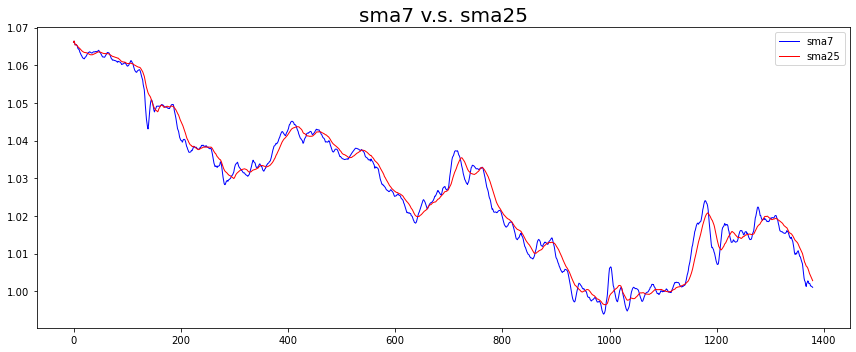

In [60]:
# Main chart - SMA_7 and SMA_25
fig, ax = plt.subplots(figsize=(12,5))

ax.set_title('sma7 v.s. sma25', fontsize=20)

ax.plot(index, sma7_lst, 'b', lw=1, label='sma7')
ax.plot(index, sma25_lst, 'r', lw=1, label='sma25')
ax.legend(loc='best')

fig.tight_layout()

In [61]:
macd_lst = sample_x_df['macd'].loc[sample_x_df['sample_id']==idx].tolist()
macds_lst = sample_x_df['macds'].loc[sample_x_df['sample_id']==idx].tolist()

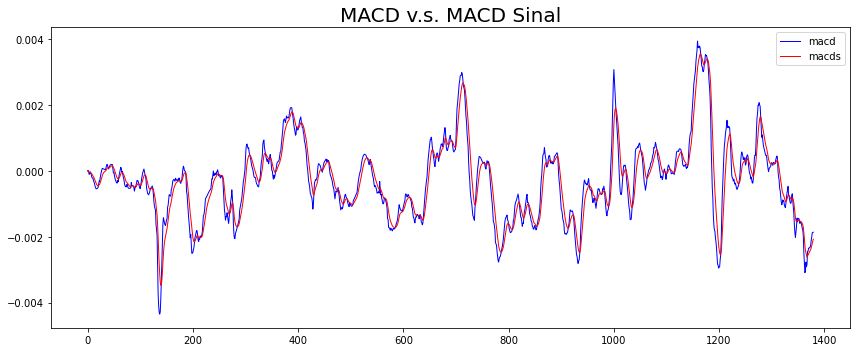

In [62]:
# index chart - MACD and MACDs
fig, ax = plt.subplots(figsize=(12,5))

ax.set_title('MACD v.s. MACD Sinal', fontsize=20)

ax.plot(index, macd_lst, 'b', lw=1, label='macd')
ax.plot(index, macds_lst, 'r', lw=1, label='macds')
ax.legend(loc='best')

fig.tight_layout()

In [63]:
macdo_lst = sample_x_df['macdo'].loc[sample_x_df['sample_id']==idx].tolist()

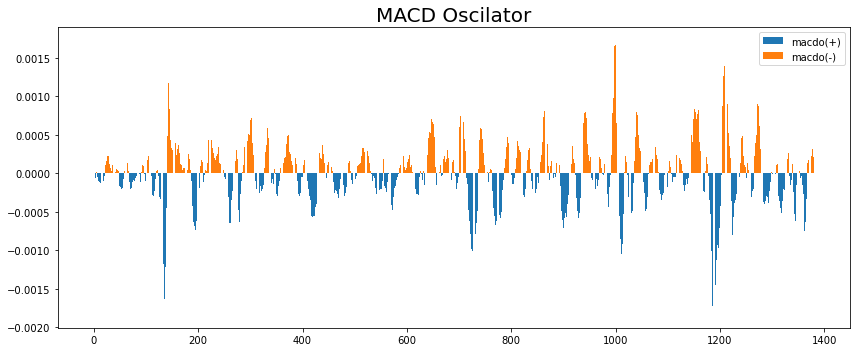

In [64]:
# index chart - MACDo
fig, ax = plt.subplots(figsize=(12,5))

ax.set_title('MACD Oscilator', fontsize=20)

ax.bar(index, [0 if i > 0 else i for i in macdo_lst], lw=1, label='macdo(+)')
ax.bar(index, [0 if i < 0 else i for i in macdo_lst], lw=1, label='macdo(-)')
ax.legend(loc='best')

fig.tight_layout()

## 샘플 확인하기

In [65]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

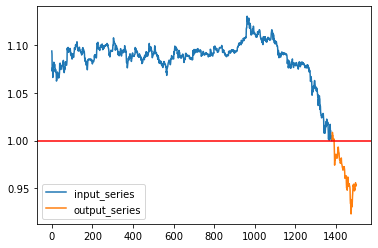

In [66]:
# open
idx = 1012
plot_series(train_x_array[idx,:,1], train_y_array[idx,:,1])
plt.show()

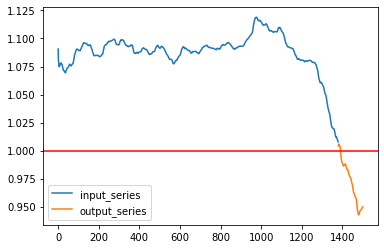

In [67]:
# open
idx = 1012
plot_series(train_x_array[idx,:,10], train_y_array[idx,:,10])
plt.show()

In [ ]:
macd_x_series = train_x_array[idx,:,11]
macd_y_series = train_y_array[idx,:,11]
plt.plot(macd_x_series, label = 'input_series')
plt.plot(np.arange(len(macd_x_series), len(macd_x_series)+len(macd_y_series)),
         macd_y_series, label = 'output_series')

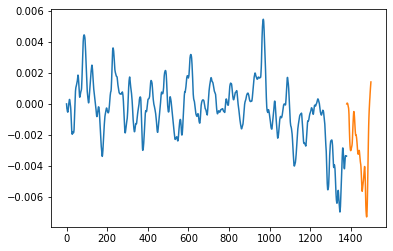

In [77]:
x_series = train_x_array[idx,:,12]
y_series = train_y_array[idx,:,12]

plt.plot(x_series, label = 'input_series')
plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
         y_series, label = 'output_series')

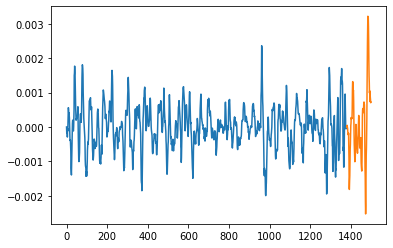

In [75]:
x_series = train_x_array[idx,:,13]
y_series = train_y_array[idx,:,13]

plt.plot(x_series, label = 'input_series')
plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
         y_series, label = 'output_series')

In [78]:
start_time = '2021-01-31 00:00:00'
start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')

In [ ]:
macd_x_series = train_x_array[idx,:,11]
macd_y_series = train_y_array[idx,:,11]

macd_x_df = pd.DataFrame()
macd_x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, macd_x_series.shape[0]+1).tolist()]
macd_x_df['y'] = macd_y_series.tolist()

macd_x_df.head()

In [88]:
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=False,
                  weekly_seasonality=False, daily_seasonality=False)
prophet.fit(macd_x_df)

In [89]:
# 120분 테스트 데이터를 예측합니다.
future_data = prophet.make_future_dataframe(periods=120, freq='min')
forecast_data = prophet.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
1495,2021-02-01 00:56:00,-0.004980,-0.006959,-0.002946
1496,2021-02-01 00:57:00,-0.004991,-0.007057,-0.002948
1497,2021-02-01 00:58:00,-0.005001,-0.007204,-0.002866
1498,2021-02-01 00:59:00,-0.005011,-0.007050,-0.003002
1499,2021-02-01 01:00:00,-0.005022,-0.007198,-0.002991


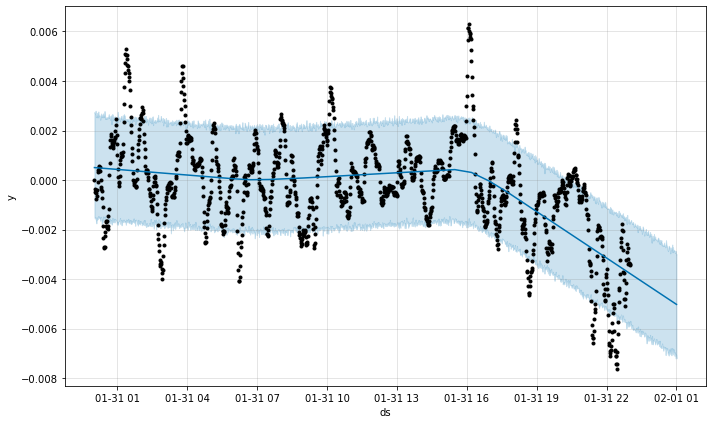

In [90]:
# 만들어진 데이터를 확인합니다.
fig1 = prophet.plot(forecast_data)

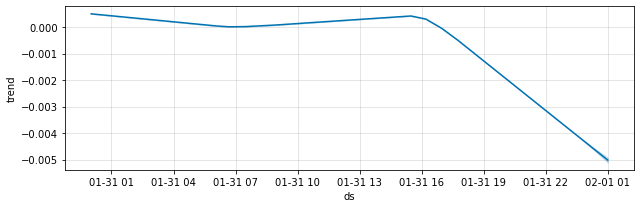

In [91]:
# 데이터의 추세를 확인합니다.
fig2 = prophet.plot_components(forecast_data)

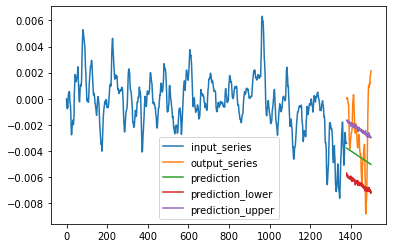

In [96]:
pred_y = forecast_data.yhat.values[-120:]
pred_y_lower = forecast_data.yhat_lower.values[-120:]
pred_y_upper = forecast_data.yhat_upper.values[-120:]

plt.plot(x_series, label = 'input_series')
plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
         y_series, label = 'output_series')

plt.plot(np.arange(1380, 1380+120), pred_y, label = 'prediction')
plt.plot(np.arange(1380, 1380+120), pred_y_lower, label = 'prediction_lower')
plt.plot(np.arange(1380, 1380+120), pred_y_upper, label = 'prediction_upper')
plt.legend()
plt.show()

macd 지표로 봤을때, 좀더 흐름을 볼 수 있게되었음을 알 수 있다. 

In [ ]:
x_series = train_x_array[idx,:,1]
y_series = train_y_array[idx,:,1]

x_df = pd.DataFrame()
x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
x_df['y'] = x_series.tolist()

x_df.head()

## 2) validation set 훈련하기
### <1> validation 데이터 생성하기

In [98]:
# train 데이터 상단의 300개 샘플로 validation set를 구성하여 학습 및 추론
valid_x_macd_df = train_x_df[train_x_macd_df.sample_id < 300]
valid_y_macd_df = train_y_df[train_y_macd_df.sample_id < 300]

valid_x_array = df2d_to_array3d(valid_x_macd_df)
valid_y_array = df2d_to_array3d(valid_y_macd_df)
valid_pred_array = np.zeros([300, 120])

### <2> 학습 및 추론하기

In [99]:
for idx in tqdm(range(valid_x_array.shape[0])):
    try:
        x_series = valid_x_array[idx,:,1]

        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()

        prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=False,
                  weekly_seasonality=False, daily_seasonality=False)
        prophet.fit(x_df)

        # 120분 테스트 데이터를 예측합니다.
        future_data = prophet.make_future_dataframe(periods=120, freq='min')
        forecast_data = prophet.predict(future_data)

        pred_y = forecast_data.yhat.values[-120:]
        pred_y_lower = forecast_data.yhat_lower.values[-120:]
        pred_y_upper = forecast_data.yhat_upper.values[-120:]

        valid_pred_array[idx,:] = pred_y
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

100%|██████████| 300/300 [12:28<00:00,  2.49s/it]


### <3> valid_pred_array 로부터 buy_quantity, sell_time 구하기

In [100]:
def array_to_submission(x_array, pred_array):
    # 입력 x_arrry와 출력 pred_arry를 통해서 
    # buy_quantitiy와 sell_time을 결정
    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 1
    
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])
    buy_price = np.array(buy_price)
    # 105% 이상 상승한하고 예측한 sample에 대해서만 100% 매수
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.05) * 1
    # 모델이 예측값 중 최대 값에 해당하는 시간에 매도
    submission['sell_time'] = np.argmax(pred_array, axis = 1)
    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    return submission

In [101]:
valid_submission = array_to_submission(valid_x_array, valid_pred_array)

In [102]:
valid_submission

,sample_id,buy_quantity,sell_time
0,0,0,119
1,1,0,0
2,2,0,0
3,3,0,119
4,4,0,0
...,...,...,...
295,295,0,119
296,296,0,0
297,297,0,0
298,298,0,0


In [103]:
# 전체 300가지 sample에 대해
# case에서 105% 이상 상승하는 값 세기 
valid_submission.buy_quantity.value_counts()

0    297
1      3
Name: buy_quantity, dtype: int64

### <4> 투자 후 금액 계산하기

In [104]:
def df2d_to_answer(df_2d):
    # valid_y_df로부터
    # open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 
    # 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index


def COIN(y_df, submission, df2d_to_answer = df2d_to_answer):
    # 2차원 데이터프레임에서 open 시점 데이터만 추출하여 array로 복원
    # sample_id정보를 index에 저장
    y_array, index = df2d_to_answer(y_df)
    
    # index 기준으로 submission을 다시 선택
    submission = submission.set_index(submission.columns[0])
    submission = submission.iloc[index, :]    
    
    # 초기 투자 비용은 10000 달러
    total_momey      = 10000 # dolors
    total_momey_list = []
    
    # 가장 처음 sample_id값
    start_index = submission.index[0]
    for row_idx in submission.index:
        sell_time  = submission.loc[row_idx, 'sell_time']
        buy_price  = y_array[row_idx - start_index, 0]
        sell_price = y_array[row_idx - start_index, sell_time]
        buy_quantity = submission.loc[row_idx, 'buy_quantity'] * total_momey
        residual = total_momey - buy_quantity
        ratio = sell_price / buy_price
        total_momey = buy_quantity * ratio * 0.9995 * 0.9995 + residual        
        total_momey_list.append(total_momey)
        
    return total_momey, total_momey_list

In [106]:
total_momey, total_momey_list = COIN(valid_y_macd_df,
                                     valid_submission)

In [107]:
# 투자 후 금액
print(total_momey)

10476.210928695973


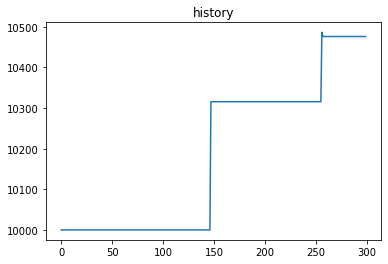

In [108]:
# 투자 히스토리
plt.plot(total_momey_list)
plt.title("history")
plt.show()

## test 데이터 학습하고 추론하기

In [ ]:
test_pred_array = np.zeros([test_x_array.shape[0],
                           120])
for idx in tqdm(range(test_x_array.shape[0])):
    try:
        x_series = test_x_array[idx,:,1]

        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()

        prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=False,
                  weekly_seasonality=False, daily_seasonality=False)
        prophet.fit(x_df)

        # 120분 테스트 데이터를 예측합니다.
        future_data = prophet.make_future_dataframe(periods=120, freq='min')
        forecast_data = prophet.predict(future_data)

        pred_y = forecast_data.yhat.values[-120:]
        pred_y_lower = forecast_data.yhat_lower.values[-120:]
        pred_y_upper = forecast_data.yhat_upper.values[-120:]

        test_pred_array[idx,:] = pred_y
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

 42%|████▏     | 223/529 [09:19<12:49,  2.51s/it]

222  샘플은 수렴하지 않습니다.


 43%|████▎     | 226/529 [09:26<12:36,  2.50s/it]

## 추론한 test_pred_array를 바탕으로 submission df 생성하기

In [ ]:
test_submission = array_to_submission(test_x_array, test_pred_array)

In [ ]:
test_submission

In [ ]:
# 전체 300가지 sample에 대해
# case에서 105% 이상 상승하는 값 세기 
test_submission.buy_quantity.value_counts()

In [ ]:
total_momey, total_momey_list = COIN(valid_y_macd_df,
                                     test_submission)

In [ ]:
submission.to_csv(data_path+"/MACD_frophet_baseline_submission_proh.csv", index = False)